### Thực hiện 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-08-15 14:24:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 173.194.218.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-08-15 14:24:40 (111 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



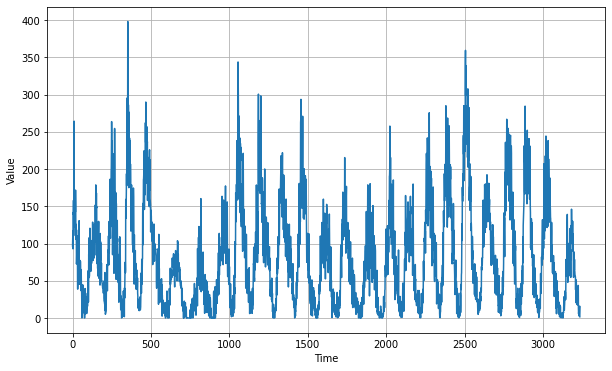

In [ ]:
import csv
time_step = []
temps = []
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    # print(row)
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)
series = series.flatten()
series

[[0.24284279]
 [0.26192868]
 [0.29306881]
 ...
 [0.03314917]
 [0.03992968]
 [0.00401808]]


array([0.24284279, 0.26192868, 0.29306881, ..., 0.03314917, 0.03992968,
       0.00401808])

In [ ]:
len(series)

3235

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

In [ ]:
len(x_train)

3000

In [ ]:
len(x_valid)

235

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

In [ ]:
train_set.take(1)

<TakeDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
one = list(train_set.take(1).as_numpy_iterator())[0]

In [ ]:
one[0].shape

(64, 60, 1)

In [ ]:
one[1].shape

(64, 60, 1)

#Mô hình

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [ ]:
model = Sequential([
      LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
      Dense(32, activation='relu'),
      Dense(1)
])


In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
tf.keras.losses.Huber()

In [ ]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100)

Epoch 1/100
46/46 [==============================] - 5s 45ms/step - loss: 0.0068 - mae: 0.0809
Epoch 2/100
46/46 [==============================] - 2s 45ms/step - loss: 0.0026 - mae: 0.0512
Epoch 3/100
46/46 [==============================] - 2s 44ms/step - loss: 0.0024 - mae: 0.0493
Epoch 4/100
46/46 [==============================] - 2s 44ms/step - loss: 0.0023 - mae: 0.0483
Epoch 5/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0022 - mae: 0.0476
Epoch 6/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0022 - mae: 0.0471
Epoch 7/100
46/46 [==============================] - 2s 42ms/step - loss: 0.0021 - mae: 0.0466
Epoch 8/100
46/46 [==============================] - 2s 44ms/step - loss: 0.0021 - mae: 0.0462
Epoch 9/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0021 - mae: 0.0460
Epoch 10/100
46/46 [==============================] - 2s 43ms/step - loss: 0.0020 - mae: 0.0457
Epoch 11/100
46/46 [=============================

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.03574582

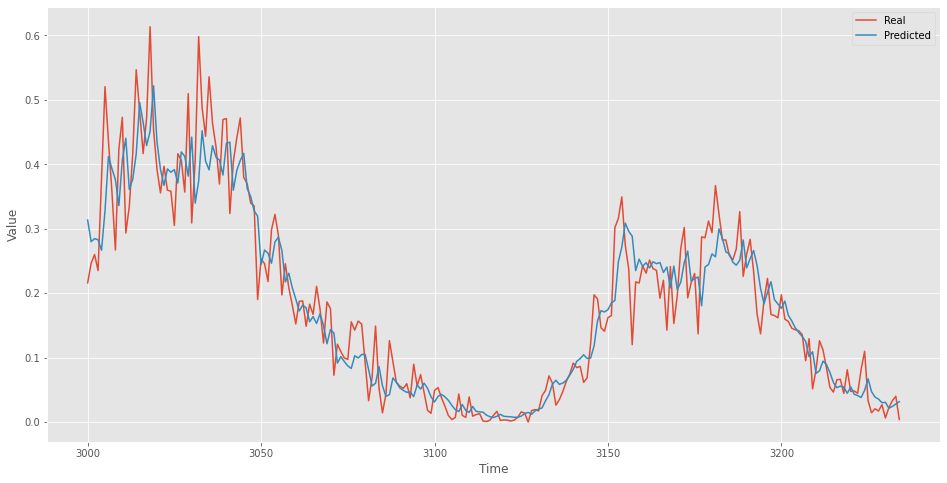

In [ ]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast)
    labels = ['Real', 'Predicted']
    plt.legend(labels)
    plt.show()

In [ ]:

model.save("mymodel.h5")